# Regression with a Crab Age Dataset
In this notebook, we will be predicting the age of crabs based on the given dataset. You can find the competition and the dataset [here](https://www.kaggle.com/competitions/playground-series-s3e16).

<div align="center">
<img src="https://www.kaggle.com/competitions/51983/images/header" />
</div>

## 1. Importing Libraries

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import lightgbm as lgb
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score, mean_squared_error

import warnings

### Configuration

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('darkgrid')

## 2. Loading Data

In [3]:
df = pd.read_csv('train.csv', index_col='id')

In [4]:
df.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
id,,,,,,,,,
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74051 entries, 0 to 74050
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             74051 non-null  object 
 1   Length          74051 non-null  float64
 2   Diameter        74051 non-null  float64
 3   Height          74051 non-null  float64
 4   Weight          74051 non-null  float64
 5   Shucked Weight  74051 non-null  float64
 6   Viscera Weight  74051 non-null  float64
 7   Shell Weight    74051 non-null  float64
 8   Age             74051 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 5.6+ MB


In [6]:
df.shape

(74051, 9)

In [7]:
df.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

## 3. Exploratory Data Analysis

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Length,74051.0,1.317460,0.287757,0.187500,1.150000,1.375000,1.537500,2.012815
Diameter,74051.0,1.024496,0.237396,0.137500,0.887500,1.075000,1.200000,1.612500
Height,74051.0,0.348089,0.092034,0.000000,0.300000,0.362500,0.412500,2.825000
Weight,74051.0,23.385217,12.648153,0.056699,13.437663,23.799405,32.162508,80.101512
Shucked Weight,74051.0,10.104270,5.618025,0.028349,5.712424,9.908150,14.033003,42.184056
Viscera Weight,74051.0,5.058386,2.792729,0.042524,2.863300,4.989512,6.988152,21.545620
Shell Weight,74051.0,6.723870,3.584372,0.042524,3.968930,6.931453,9.071840,28.491248
Age,74051.0,9.967806,3.175189,1.000000,8.000000,10.000000,11.000000,29.000000


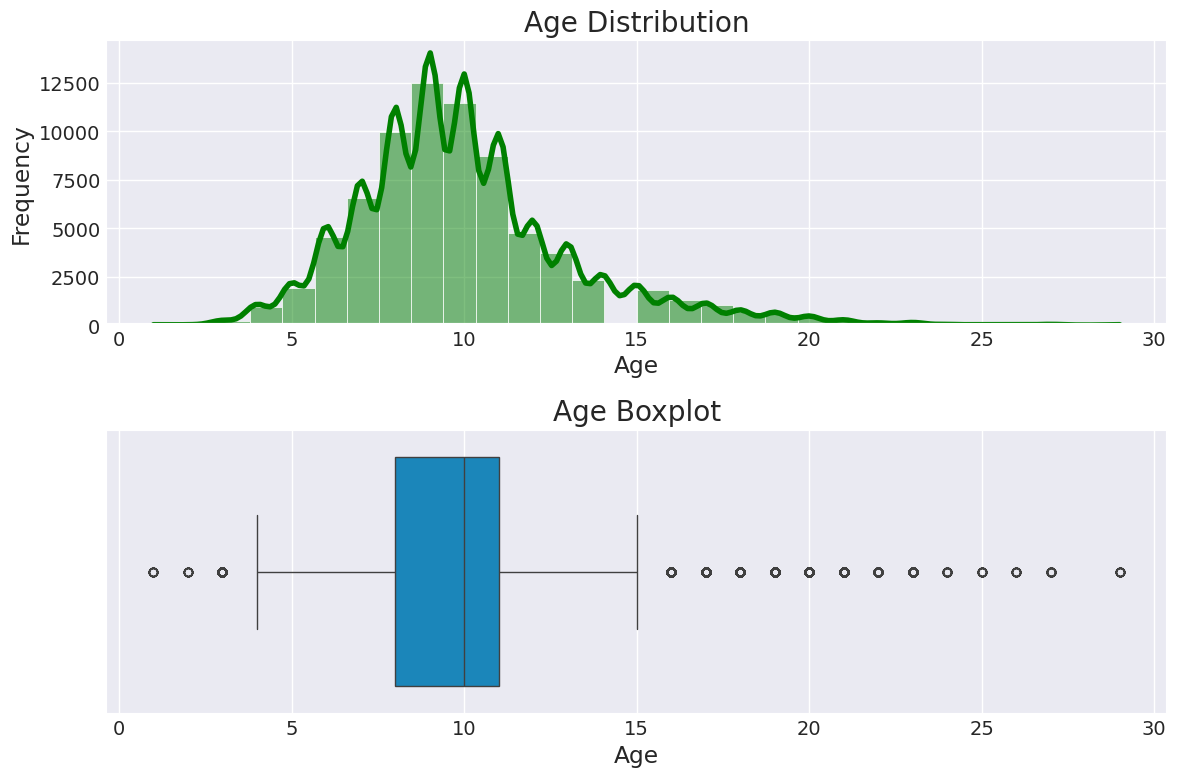

In [9]:
plt.subplot(211)
sns.histplot(df['Age'], bins=30, kde=True, color='g')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(212)
sns.boxplot(df['Age'], orient='h')
plt.title('Age Boxplot')
plt.xlabel('Age')

plt.tight_layout()

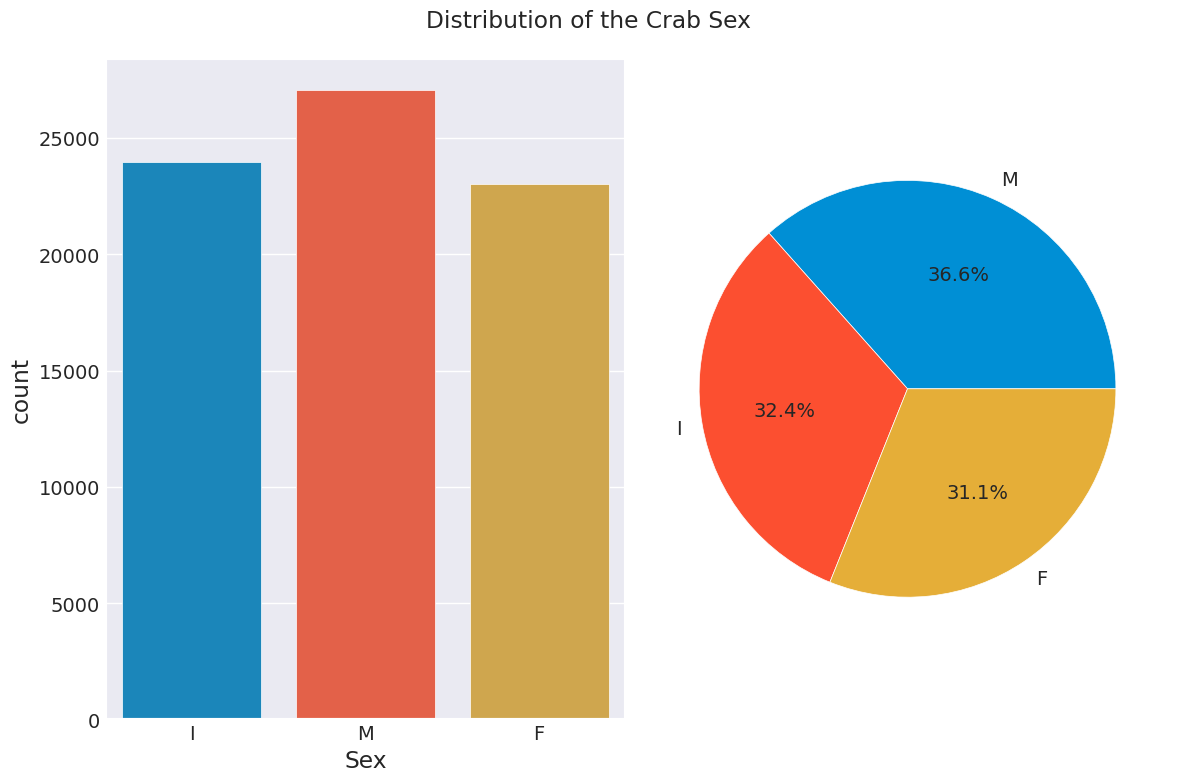

In [27]:
plt.subplot(121)
sns.countplot(x=df['Sex'], hue=df['Sex'])

plt.subplot(122)
df.Sex.value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.ylabel('')

plt.suptitle('Distribution of the Crab Sex')
plt.tight_layout()

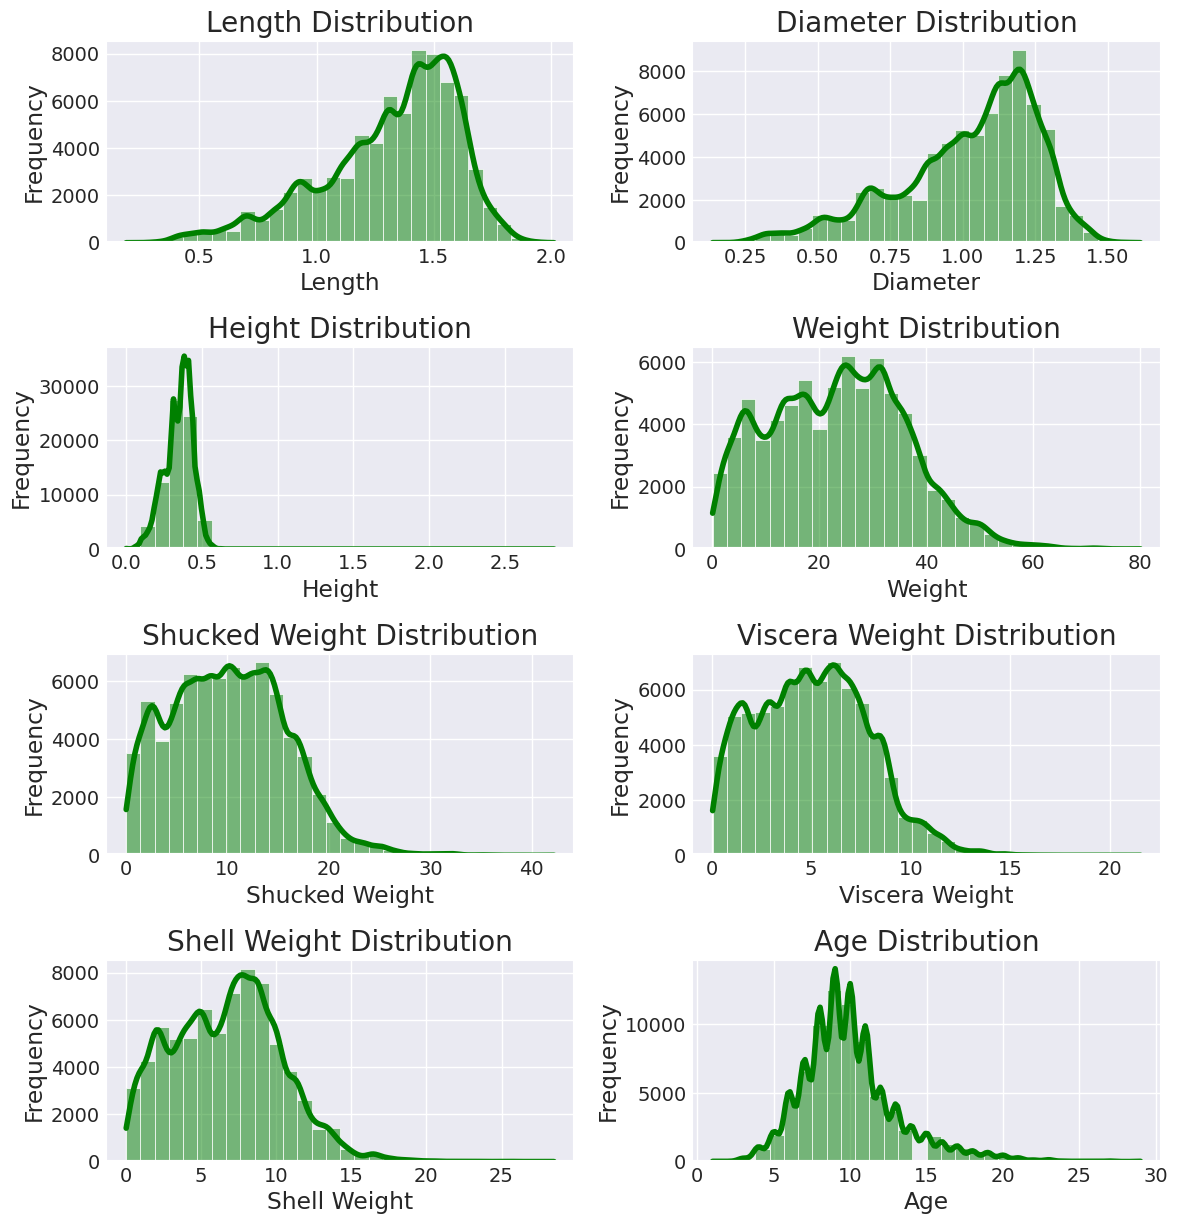

In [11]:
plt.figure(figsize=(12, 15))
for i, c in enumerate(df.columns[1:]):
    plt.subplot(5, 2, i+1)
    sns.histplot(df[c], bins=30, kde=True, color='g')
    plt.title(f'{c} Distribution')
    plt.xlabel(c)
    plt.ylabel('Frequency')
plt.tight_layout()

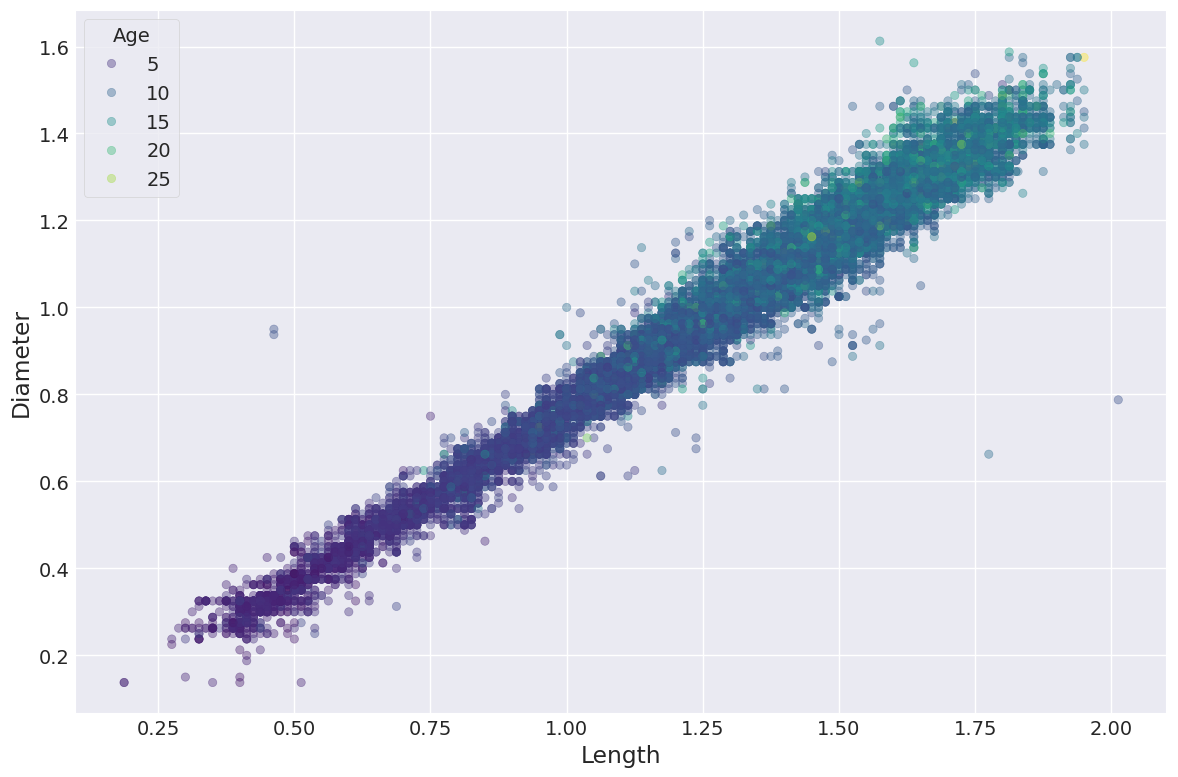

In [12]:
sns.scatterplot(
    df,
    x='Length',
    y='Diameter',
    hue='Age',
    palette='viridis',
    edgecolor=None,
    alpha=0.4
)
plt.tight_layout()

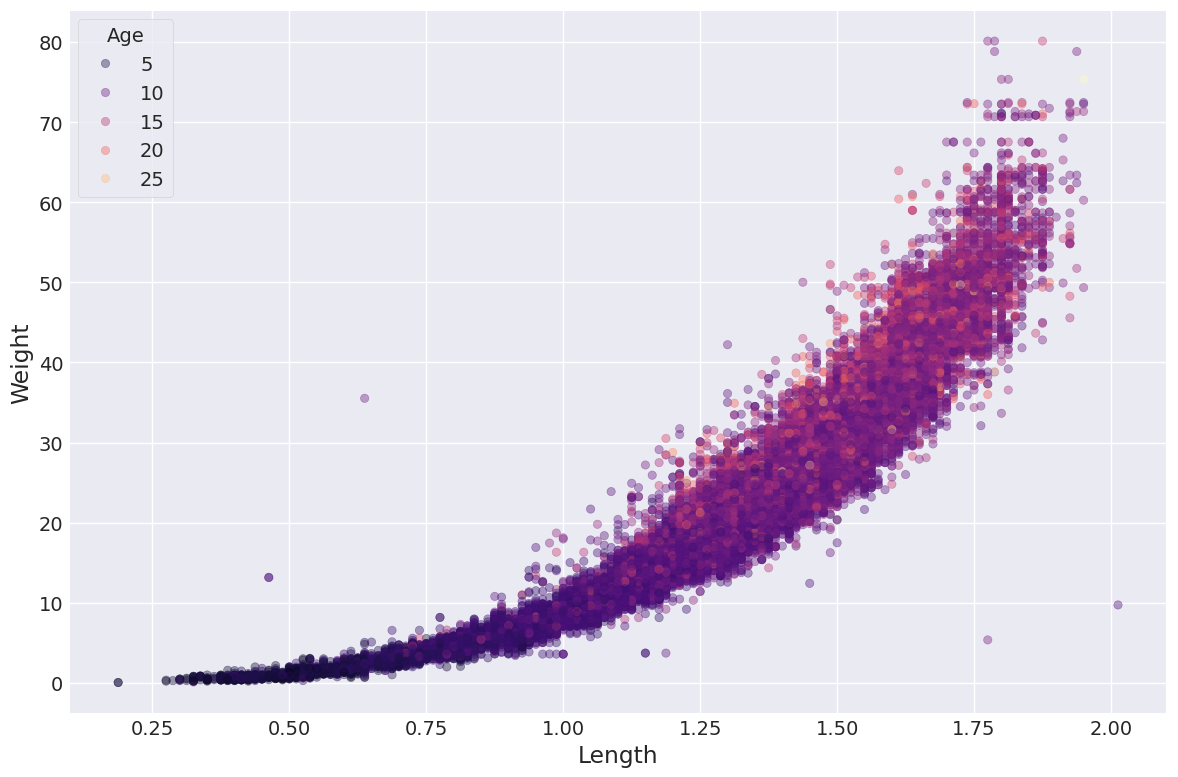

In [13]:
sns.scatterplot(
    df,
    x='Length',
    y='Weight',
    hue='Age',
    palette='magma',
    edgecolor=None,
    alpha=0.4
)
plt.tight_layout()

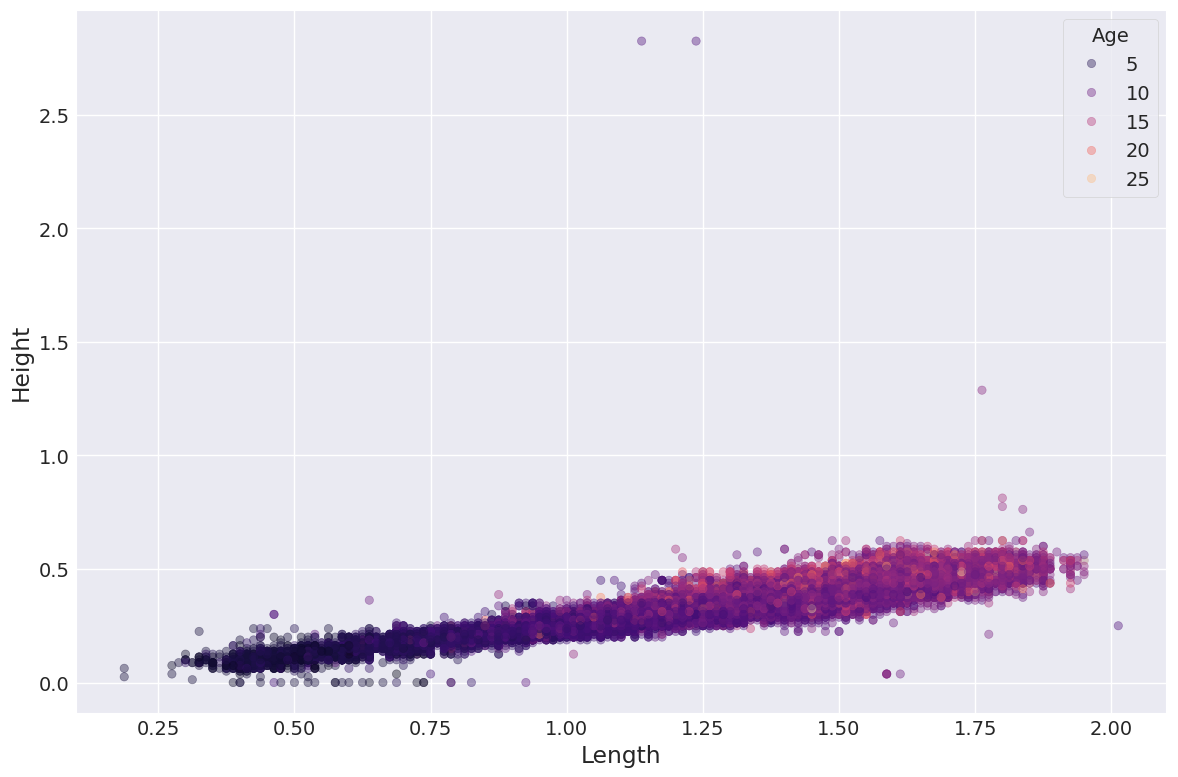

In [14]:
sns.scatterplot(
    df,
    x='Length',
    y='Height',
    hue='Age',
    palette='magma',
    edgecolor=None,
    alpha=0.4
)
plt.tight_layout()

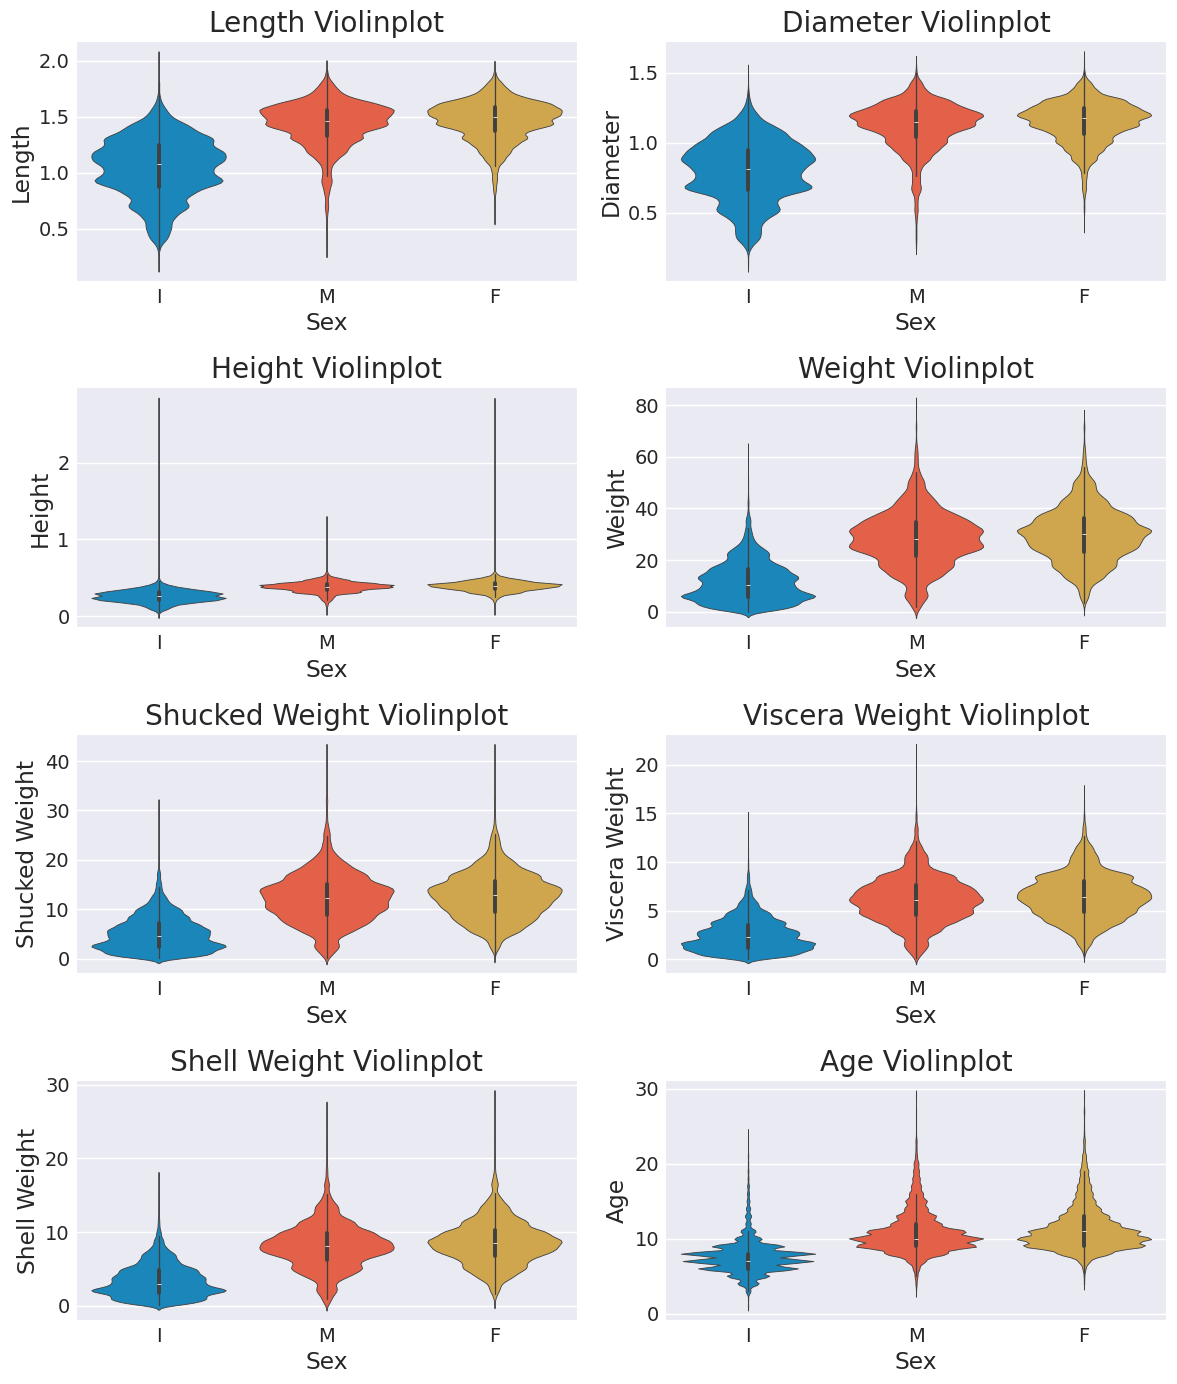

In [16]:
plt.figure(figsize=(12, 17))
for i, c in enumerate(df.columns[1:]):
    plt.subplot(5, 2, i+1)
    sns.violinplot(x=df['Sex'], y=df[c], hue=df['Sex'])
    plt.title(f'{c} Violinplot')
    plt.xlabel('Sex')
    plt.ylabel(c)
plt.tight_layout()

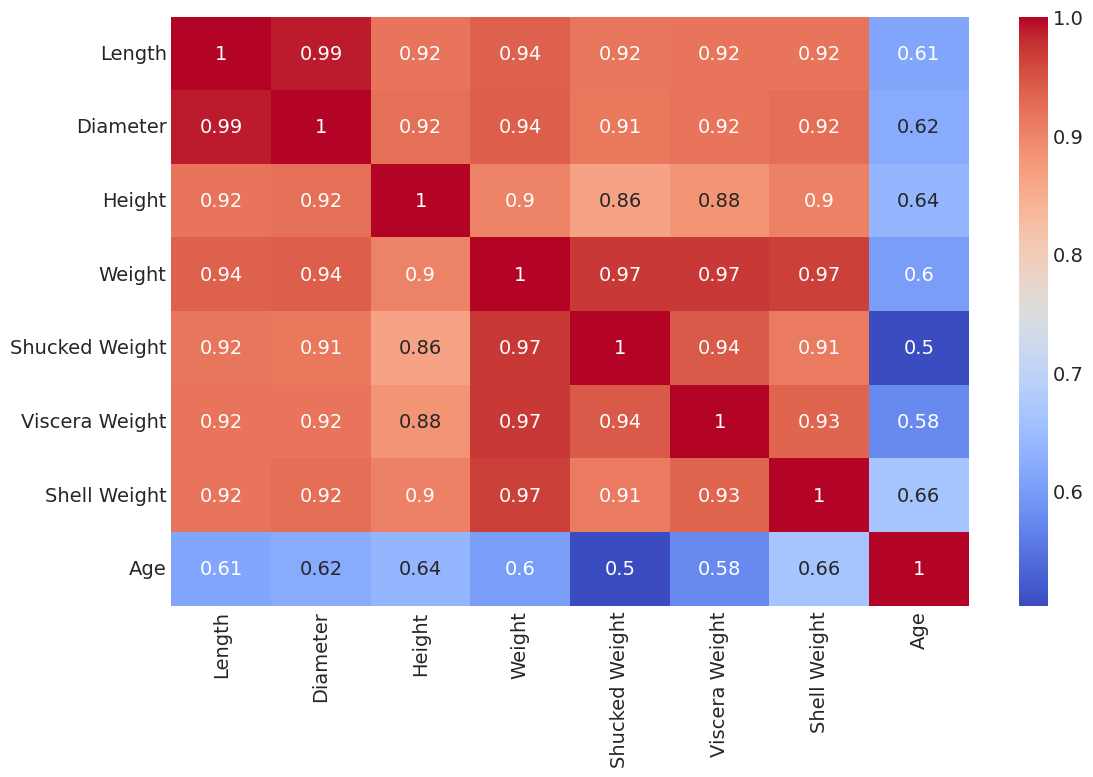

In [21]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.tight_layout()

In [22]:
df.corr(numeric_only=True)['Age'].sort_values(ascending=False)

Age               1.000000
Shell Weight      0.663473
Height            0.638067
Diameter          0.621256
Length            0.612843
Weight            0.601195
Viscera Weight    0.576808
Shucked Weight    0.503320
Name: Age, dtype: float64

## 4. Data Preprocessing

In [32]:
df['Sex'] = df['Sex'].astype('category')

In [33]:
x = df.drop(columns=['Age'])
y = df[['Age']]

In [ ]:
x_dummies = pd.get_dummies(x)

In [37]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_dummies)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [40]:
x_train.shape, y_train.shape

((59240, 10), (59240, 1))

## 5. Model Training

In [42]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "ExtraTreeRegressor": ExtraTreeRegressor(),
    "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5),
    "LightGBM": lgb.LGBMRegressor(verbose=-1),
    "XGBoost": xgb.XGBRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "RandomForestRegressor": RandomForestRegressor()
}


def evaluate(x_train, y_train, x_test, y_test):
    results = []
    for name, model in tqdm(models.items()):
        print(f"Training {name} model...")
        y_pred = model.fit(x_train, y_train).predict(x_test)
        
        results.append({
            "Model": name,
            "R2_Score": r2_score(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "RMSE": mean_squared_error(y_test, y_pred)**0.5
        })
    report = pd.DataFrame(results).sort_values('R2_Score', ascending=False)
    report.reset_index(drop=True, inplace=True)
    return report

In [43]:
evaluate(x_train, y_train, x_test, y_test)

  0%|          | 0/10 [00:00<?, ?it/s]

Training LinearRegression model...
Training Ridge model...
Training Lasso model...
Training DecisionTreeRegressor model...
Training ExtraTreeRegressor model...
Training KNeighborsRegressor model...
Training LightGBM model...
Training XGBoost model...
Training GradientBoostingRegressor model...
Training RandomForestRegressor model...


,Model,R2_Score,MSE,RMSE
0,LightGBM,0.592292,4.155188,2.038428
1,GradientBoostingRegressor,0.583948,4.240224,2.059180
2,XGBoost,0.580624,4.274100,2.067390
3,RandomForestRegressor,0.568806,4.394543,2.096317
4,LinearRegression,0.556981,4.515056,2.124866
5,Ridge,0.556801,4.516891,2.125298
6,KNeighborsRegressor,0.511564,4.977930,2.231127
7,DecisionTreeRegressor,0.147192,8.691446,2.948126
8,ExtraTreeRegressor,0.131101,8.855445,2.975810
9,Lasso,-0.000014,10.191707,3.192445


### Hyperparameter Tuning

In [46]:
# Hyperparameters for grid search
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 500],
    'max_depth': [3, 5],
}

In [47]:
%%time
grid_search = GridSearchCV(
    estimator=lgb.LGBMRegressor(verbose=-1),
    param_grid=param_grid,
    cv=5,
    scoring='r2'
)
grid_search.fit(x_train, y_train)

CPU times: user 5min 53s, sys: 1.22 s, total: 5min 54s
Wall time: 1min 29s


,estimator,LGBMRegressor(verbose=-1)
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5], 'n_estimators': [50, 100, ...], 'num_leaves': [31, 50, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


In [48]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'num_leaves': 31}

In [49]:
grid_search.best_score_

np.float64(0.583267439351193)

## 6. Building the Pipeline, Saving the Model & Making Submission

In [50]:
x.select_dtypes(include=['number']).columns

Index(['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight'],
      dtype='object')

In [52]:
preprocessor = ColumnTransformer([
    ('scaler', MinMaxScaler(), x.select_dtypes(include=['number']).columns),
    ('encoder', OneHotEncoder(), ['Sex'])
])
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMRegressor(verbose=-1))
])
pipeline.fit(x, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...), ('encoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [53]:
y_pred = pipeline.predict(x)

print(f"R2 Score : {r2_score(y, y_pred)}")
print(f"MSE      : {mean_squared_error(y, y_pred)}")
print(f"RMSE     : {mean_squared_error(y, y_pred)**0.5}")

R2 Score : 0.6172997269270158
MSE      : 3.8582656361750094
RMSE     : 1.9642468368753987


In [54]:
joblib.dump(pipeline, 'crab_age_prediction_pipeline.pkl')

['crab_age_prediction_pipeline.pkl']

In [55]:
test_df = pd.read_csv('test.csv', index_col='id')
predictions = pipeline.predict(test_df)

submission = pd.DataFrame({
    'id': test_df.index,
    'Age': predictions
})
submission.head()

,id,Age
0,74051,7.549825
1,74052,7.871737
2,74053,10.814155
3,74054,9.631765
4,74055,7.507709


In [56]:
submission.to_csv('submission.csv', index=False)

## 7. Conclusion
- Cleaned and explored the dataset; built a reproducible preprocessing pipeline.
- Trained and compared regression models with cross-validation and tuning.
- Final model achieves solid performance and is packaged for submission.
- Next: engineer interactions, try more ensembles, and refine hyperparameters.